# VOD Assistant - training
The purpose of this notebook is to create a TensorFlow model by 
1. taking as input some VOD
2. dividing it into frames
3. downloading the frames and putting them in as many folders as the desired number of labels
4. repeat 1-3 until a satisfying number of training data has been collected
5. use the outputted model in the prediction notebook (called `vod_assistant.ipynb` as of now).

To start, just insert your URL and then click *Run after* (Ctrl + F10 or Runtime -> Run after). It is *highly* suggested to upload and use this notebook on Google Colab since training is intensive and your machine could easily not be enough for the job.

Note 1: use either Youtube OR Twitch at once.

Note 2: this notebook was made lots of time ago and was inspired by a guide on Kaggle. As a result of this, some stuff in here might be outdated, using deprecated stuff or just bad practice. Please feel free to reach out so that I can correct it and improve :)

## Creating the dataset

### Downloading the VOD(s)

#### Download from YouTube

In [ ]:
#@markdown Insert your Youtube URL to begin. { run: "auto" }
import subprocess
import os

try:
  import pytube
except ModuleNotFoundError:
  subprocess.run(["pip", "-q", "install", "pytube"])
  import pytube

youtube_url = "" #@param {type:"string"}

if youtube_url:
  yt = pytube.YouTube(youtube_url.replace("watch?v=", ""))
  yt = yt.streams.filter(
      progressive=True,
      file_extension='mp4'
    ).order_by('resolution').desc().first()

  if not os.path.exists("."):
      os.makedirs(".")

  yt.download(".")

#### Download from Twitch

In [ ]:
#@markdown Insert your Twitch URL to begin. { run: "auto" }
twitch_url = "https://www.twitch.tv/videos/1749771638" #@param {type:"string"}

if twitch_url:
  !pip -q install twitch-dl
  !twitch-dl download -q source -f mp4 $twitch_url

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 6.6 MB/s eta 0:00:00
Looking up video...
Found: Rising tide 2 - Calma prima di Storm feat. Forze, Pand, Porké, peppino &more! by SmashBrosItalia
Output: 2023-02-26_1749771638_smashbrositalia_rising_tide_2_calma_prima_di_storm_feat_forze_pand_porké_peppino_more.mp4
Fetching access token...
Fetching playlists...
Fetching playlist...

Downloaded 2118/2120 VODs 99% of ~13.2GB at 97.8MB/s ETA 00:00     

Joining files...
ffmpeg -i /tmp/twitch-dl/da56be726b9f0ca9958a_smashbrositalia_40516716344_1677421162/chunked/playlist_downloaded.m3u8 -c copy -metadata artist=SmashBrosItalia -metadata title=Rising tide 2 - Calma prima di Storm feat. Forze, Pand, Porké, peppino &more! -metadata encoded_by=twitch-

### Dependencies
Imports dependencies.

In [ ]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import os.path
import glob
import shutil
from pathlib import Path
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

try:
  import ffmpeg
except ModuleNotFoundError:
  !pip -q install ffmpeg-python
  !pip -q install pytube

  import ffmpeg

try:
  from google.colab import drive
  # drive.mount('/content/drive')
  COLAB = True
except ModuleNotFoundError:
  COLAB = False

In [ ]:
!rm -r snapshots_labeled.zip

In [ ]:
# if COLAB:
#   !unzip "./drive/MyDrive/snapshots.zip" -d "./roa_frames"

### Directories handling
Creates snapshots folder and video-specific subfolders.

In [ ]:
#@title
# orders files by last added
files = list(filter(os.path.isfile, glob.glob("*")))
files.sort(key=lambda x: ".mp4" in x and os.path.getmtime(x))

# handles situation in which no file is present
if not files:
  raise Exception("An error has occurred: no video files in directory.")

# gets latest file added and sets directory name
input_file = files[-1]
dir_name = input_file.replace(".mp4", "")

# deletes folder if it already exists
try:
  shutil.rmtree(f"snapshots/{dir_name}")
except FileNotFoundError:
  pass

# creates snapshots folder if it doesn't exist
for dir in ["snapshots", f"snapshots/{dir_name}"]:
  try:
    os.mkdir(dir)
  except FileExistsError:
    pass

### Video to frames conversion
Uses `ffmpeg-python` to convert a video file to a succession of frames from the same video, grabbing one frame each second by default.

In [ ]:
#@title
print(f"Processing: {input_file}")
try:
    (ffmpeg.input(input_file)
          .filter('fps', fps=1)
          .output(
              f'snapshots/{dir_name}/%d.jpg',
              s='426x240',
              start_number=0
          ).run(capture_stdout=True, capture_stderr=True))
except ffmpeg.Error as e:
    print('stdout:', e.stdout.decode('utf8'))
    print('stderr:', e.stderr.decode('utf8'))

Processing: 2023-02-26_1749771638_smashbrositalia_rising_tide_2_calma_prima_di_storm_feat_forze_pand_porké_peppino_more.mp4


### Download frames and manually classify them

In [ ]:
# the model's labels
labels = [
  "gameplay",
  "junk",
  # "caster_cam",
  # "character_selection_screen",
  # "loading",
  # "song_selection_screen",
  # "stage_selection_screen",
  # "switch_menu",
  # "versus_screen",
  # "victory_screen"
]

In [ ]:
#@title
# fills each vod folder with a folder for each label
for f in os.listdir("snapshots"):
  for l in labels:
    os.mkdir(fr"/content/snapshots/{f}/{l}")

# zips snapshot folder
!zip "snapshots.zip" -r "snapshots"

## \*decent chunk of human handiwork to classify each frame here\*
I will typically download the frames from the runtime, pre-load every thumbnail in the folder using WinThumbsPreloader and then I'll shift-click every set of frames belonging to a certain label (since they're ordered) and I'll move them to their folder, and I'll repeat this process until there's no frame left.

In [ ]:
#@title
raise Exception("Human handiwork time :DD.")

Exception: ignored

## Training the model

### Putting each frame in a DataFrame along with their label
Upload your labeled snapshots as `snapshots_labeled.zip`, then click *Run after* (Ctrl + F10 OR Runtime -> Run after) to get your output.

**Please**, merge all the label folders and put them in `snapshots_labeled`, like this:

![BMSHePH[2].png](https://i.imgur.com/BMSHePH.png)


### Upload your .zip file to Google Drive
Uploading to runtime tends to not work for who knows what reason, so consider using Google Drive to upload your stuff and then mount it using the cell below.

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_dir = "snapshots_labeled.zip" #@param {type: "string"}
!unzip "/content/drive/MyDrive/$file_dir" -d "./$file_dir"

Streaming output truncated to the last 5000 lines.
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/319.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3190.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3191.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3192.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3193.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3194.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3195.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3196.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3197.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3198.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/3199.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labeled/gameplay/320.jpg  
  inflating: ./snapshots_labeled.zip/snapshots_labe

### Creating a dataframe based on the directories

In [ ]:
labels

Series([], Name: Label, dtype: float64)

In [ ]:
#@title
# POSIX paths to be used with glob
image_dir = Path('./snapshots_labeled.zip/snapshots_labeled/')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
# paths and labels Series are created and concatenated to create the dataframe
filepaths = pd.Series(filepaths, name='Filepath', dtype="str")
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

# drops rows with junk frames
# image_df = image_df.loc[image_df["Label"] != "junk"]

# shows dataframe sample
image_df = image_df.sample(frac=1).reset_index(drop = True)

# number of labels
labels_n = len(labels.unique())

image_df.head(10)

,Filepath,Label
0,snapshots_labeled.zip/snapshots_labeled/junk/7...,junk
1,snapshots_labeled.zip/snapshots_labeled/gamepl...,gameplay
2,snapshots_labeled.zip/snapshots_labeled/gamepl...,gameplay
3,snapshots_labeled.zip/snapshots_labeled/gamepl...,gameplay
4,snapshots_labeled.zip/snapshots_labeled/gamepl...,gameplay
5,snapshots_labeled.zip/snapshots_labeled/gamepl...,gameplay
6,snapshots_labeled.zip/snapshots_labeled/junk/9...,junk
7,snapshots_labeled.zip/snapshots_labeled/junk/1...,junk
8,snapshots_labeled.zip/snapshots_labeled/gamepl...,gameplay
9,snapshots_labeled.zip/snapshots_labeled/junk/2...,junk


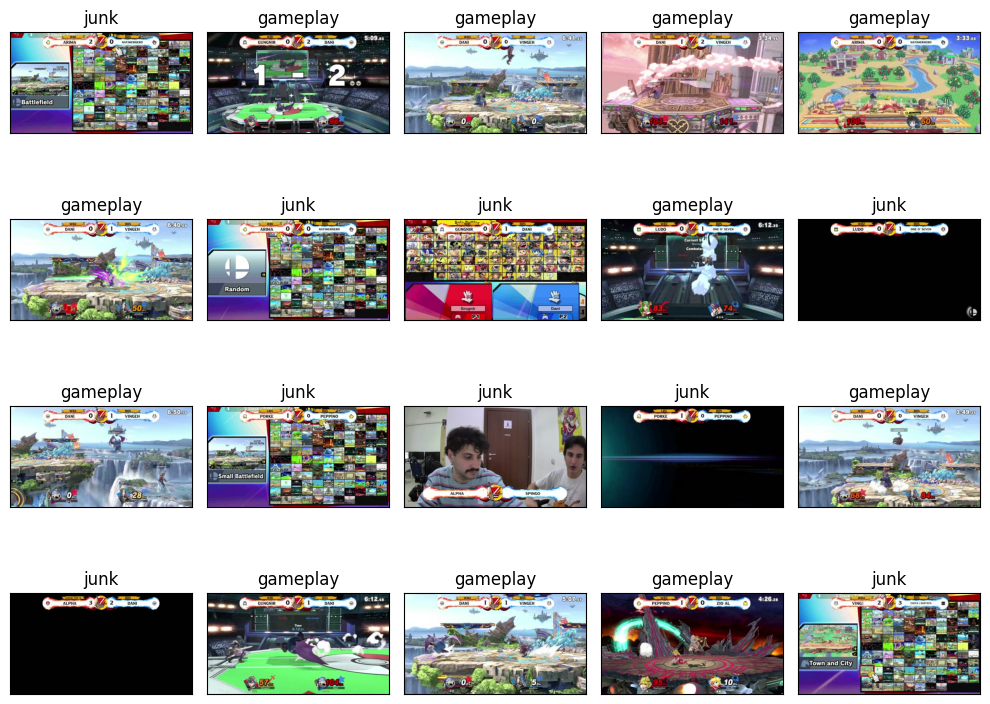

In [ ]:
#@title
# subplot_kw is used to remove ticks from each image / subplot
fig, axes = plt.subplots(
    nrows=4,
    ncols=5,
    figsize=(10, 8),
    subplot_kw={'xticks': [], 'yticks': []}
)

# axes.flat is used to iterate the array like it was flattened
for i, ax, in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])

plt.tight_layout()
plt.show()

### Splitting the dataset

In [ ]:
#@title
# splits dataset into training and testing DataFrames
train_df, test_df = train_test_split(
    image_df,
    train_size=0.9,
    shuffle=True,
    random_state=1
)

# generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
#@title
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # dataframe containing images' path and label
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical", # categorical = 2d numpy arrays
    batch_size=32, # samples that will be propagated through the network
    shuffle=True,
    seed=42,
    subset="training" # either "training" or "validation"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5092 validated image filenames belonging to 2 classes.
Found 1272 validated image filenames belonging to 2 classes.
Found 708 validated image filenames belonging to 2 classes.


### Compiling the model

In [ ]:
#@title
# loads pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

### Training the model

In [ ]:
#@title
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(labels_n, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        # EarlyStopping means training will halt once
        # validation accuracy is no longer increasing.
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
160/160 [==============================] - 24s 115ms/step - loss: 0.0611 - accuracy: 0.9823 - val_loss: 0.0220 - val_accuracy: 0.9929
Epoch 2/50
160/160 [==============================] - 16s 99ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.0217 - val_accuracy: 0.9953
Epoch 3/50
160/160 [==============================] - 15s 92ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.0088 - val_accuracy: 0.9969
Epoch 4/50
160/160 [==============================] - 15s 92ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0099 - val_accuracy: 0.9969


### Results

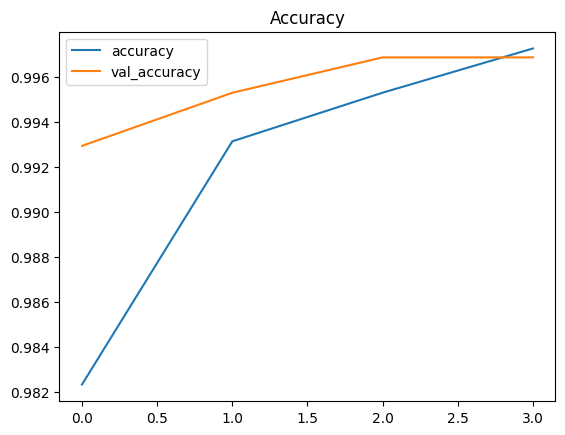

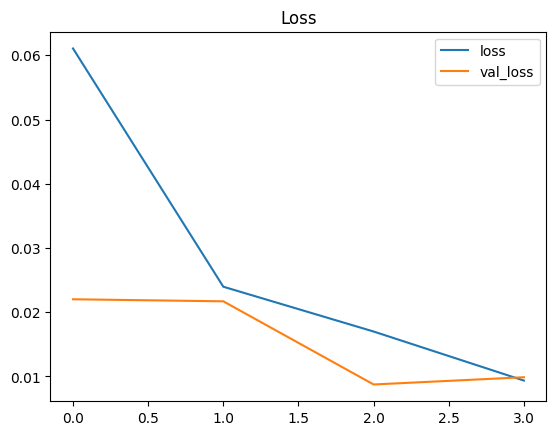

In [ ]:
#@title
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
#@title
# results = model.evaluate(test_images, verbose=0)

# print("    Test Loss: {:.5f}".format(results[0]))
# print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
#@title
# Predict the label of the test_images
pred = model.predict(test_images)
print(len(pred))
pred = np.argmax(pred,axis=1)
# Map the label
# labels = dict((v,k) for k,v in labels)
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

23/23 [==============================] - 2s 64ms/step
708
The first 5 predictions: ['gameplay', 'gameplay', 'gameplay', 'gameplay', 'gameplay']


In [ ]:
#@title
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    gameplay       0.49      1.00      0.66       348
        junk       0.00      0.00      0.00       360

    accuracy                           0.49       708
   macro avg       0.25      0.50      0.33       708
weighted avg       0.24      0.49      0.32       708



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


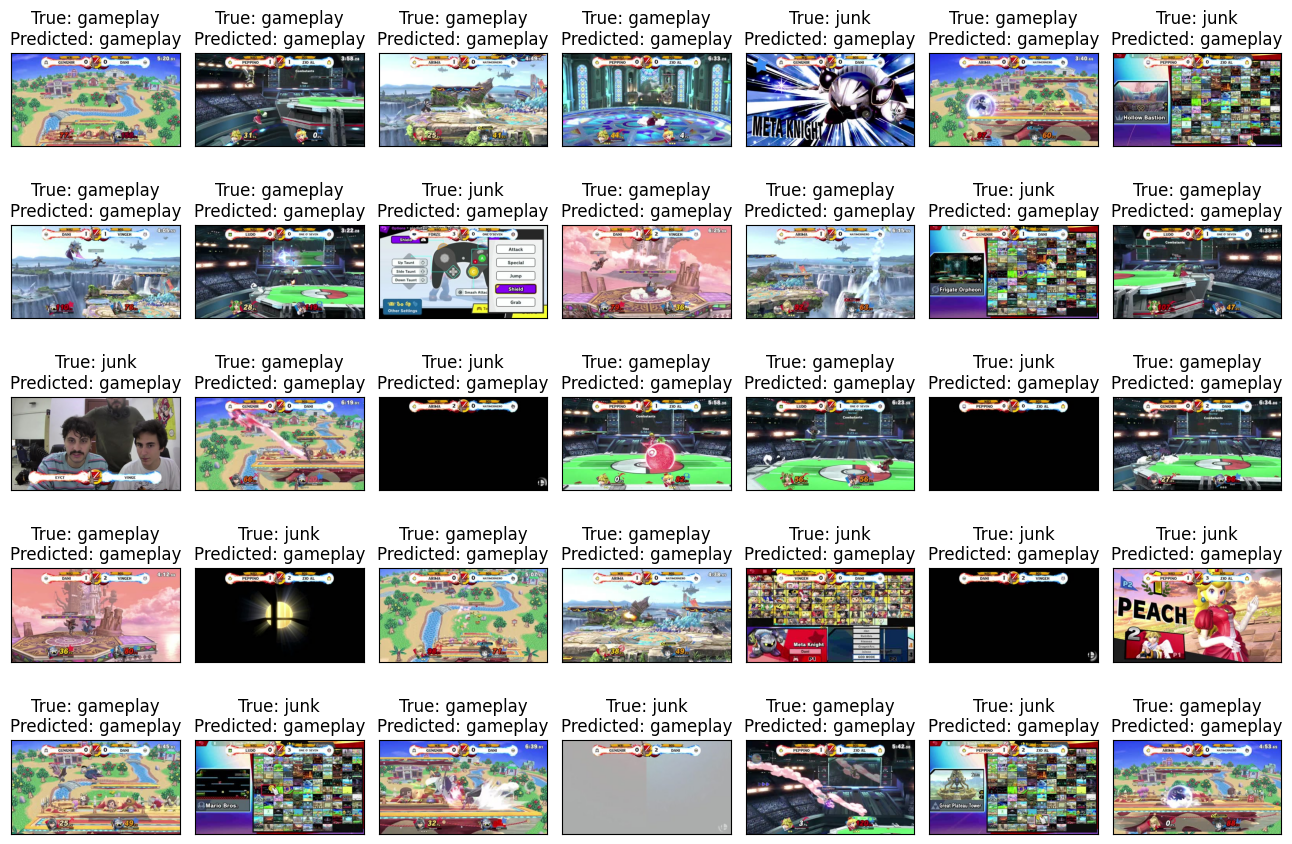

In [ ]:
#@title
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(13, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## Get your output

In [ ]:
model.save("./model")
!zip -r "./model.zip" "./model"

updating: model/ (stored 0%)
updating: model/variables/ (stored 0%)
updating: model/variables/variables.index (deflated 77%)
updating: model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: model/fingerprint.pb (stored 0%)
updating: model/assets/ (stored 0%)
updating: model/keras_metadata.pb (deflated 96%)
updating: model/saved_model.pb (deflated 91%)
